In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial
from tqdm import tqdm

## Data loading

In [2]:
DATA_ROOT='../../data'

model = pd.read_pickle('../notebooks_data/custom_model.pkl')
dataset = pd.read_pickle(f'{DATA_ROOT}/dataset.pkl')

In [3]:
full_df = pd.read_csv(f'{DATA_ROOT}/ratings_all_implicit.csv.gz')
train_df = pd.read_csv(f'{DATA_ROOT}/ratings_train_implicit.csv.gz')
games_df = pd.read_json(f'{DATA_ROOT}/bgg_GameItem.jl', lines=True)[[
    'name', 'bgg_id', 'mechanic', 'category', 'complexity',
    'max_players_best', 'min_players_best', 'max_players_rec', 'min_players_rec'
]]

features_names = pd.read_csv(f'{DATA_ROOT}/game_features_names.csv.gz').values.flatten()
game_features = pd.read_csv(f'{DATA_ROOT}/game_features.csv.gz')

In [4]:
users_profiles = pd.read_pickle(f'{DATA_ROOT}/users_profiles.pkl')

In [5]:
users_profiles.values[:, :40] *= 3

## Utils

In [6]:
def get_user_embedding(model, dataset, user_name):
    user_id = dataset.mapping()[0][user_name]
    return model.user_embeddings[user_id]

def get_user_bias(model, dataset, user_name):
    user_id = dataset.mapping()[0][user_name]
    return model.user_biases[user_id]

def get_game_embedding(model, dataset, bgg_game_id):
    game_id = dataset.mapping()[2][bgg_game_id]
    return model.item_embeddings[game_id]

def get_game_bias(model, dataset, bgg_game_id):
    game_id = dataset.mapping()[2][bgg_game_id]
    return model.item_biases[game_id]

def similarity(p1, p2):
    return 1 - spatial.distance.cosine(p1, p2)

def similarity_euc(p1, p2):
    return 1/(1 + np.linalg.norm(p1 - p2))

## Testing

In [7]:
train_counts = train_df['bgg_user_name'].value_counts()
users = train_counts[train_counts >= 10].index.values

In [8]:
random.seed(42)
np.random.seed(42)
random_users = np.random.choice(users, size=10001, replace=False)
u0 = random_users[0]
p0 = users_profiles.iloc[users_profiles.index == u0]
e0 = get_user_embedding(model=model, dataset=dataset, user_name=u0)
embedding_similarity = []
preferences_similarity = []
embedding_similarity_eucl = []
preferences_similarity_eucl = []
for ui in tqdm(random_users[1:]):
    pi = users_profiles.iloc[users_profiles.index == ui]
    ei = get_user_embedding(model=model, dataset=dataset, user_name=ui)
    embedding_similarity.append(similarity(e0, ei))
    preferences_similarity.append(similarity(p0.to_numpy(), pi.to_numpy()))
    embedding_similarity_eucl.append(similarity_euc(e0, ei))
    preferences_similarity_eucl.append(similarity_euc(p0.to_numpy(), pi.to_numpy()))

100%|██████████| 10000/10000 [02:50<00:00, 58.79it/s]


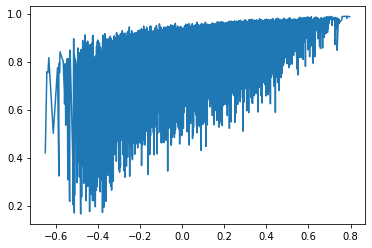

In [9]:
embedding_similarity = np.array(embedding_similarity)
preferences_similarity = np.array(preferences_similarity)
idx = np.argsort(embedding_similarity)
plt.plot(embedding_similarity[idx], preferences_similarity[idx])

Text(0, 0.5, 'Profiles similarity')

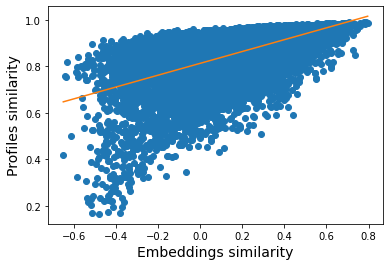

In [10]:
m, b = np.polyfit(x=embedding_similarity[idx], y=preferences_similarity[idx], deg=1)
plt.plot(embedding_similarity[idx], preferences_similarity[idx], 'o')
plt.plot(embedding_similarity[idx], m*embedding_similarity[idx] + b)
plt.xlabel("Embeddings similarity", fontsize=14)
plt.ylabel("Profiles similarity", fontsize=14)

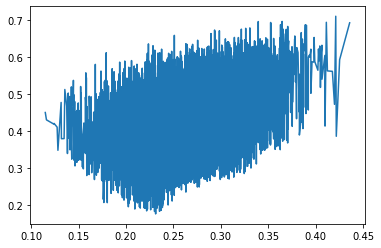

In [11]:
embedding_similarity_eucl = np.array(embedding_similarity_eucl)
preferences_similarity_eucl = np.array(preferences_similarity_eucl)
idx = np.argsort(embedding_similarity_eucl)
plt.plot(embedding_similarity_eucl[idx], preferences_similarity_eucl[idx])

Text(0, 0.5, 'Profiles similarity')

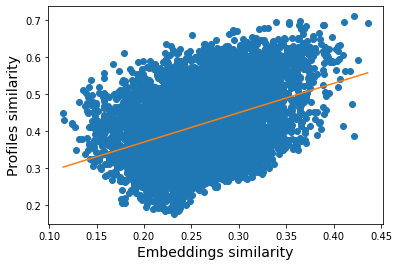

In [12]:
m, b = np.polyfit(x=embedding_similarity_eucl[idx], y=preferences_similarity_eucl[idx], deg=1)
plt.plot(embedding_similarity_eucl[idx], preferences_similarity_eucl[idx], 'o')
plt.plot(embedding_similarity_eucl[idx], m*embedding_similarity_eucl[idx] + b)
plt.xlabel("Embeddings similarity", fontsize=14)
plt.ylabel("Profiles similarity", fontsize=14)